<a href="https://colab.research.google.com/github/Emilie-Jessen/AppML-Final-Project-2024/blob/main/EfficientNet_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import tensorflow as tf
import tensorflow_hub as hub

In [33]:
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetV2B3
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.image import grayscale_to_rgb
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.layers import Lambda, Dense, InputLayer, Rescaling, Dropout, Flatten
from tensorflow.keras import Sequential

In [34]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


In [35]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [116]:
# The pictures are 48x48 pixels, but the model requires 128x128 pixels

input_pixels = 48
model_pixels = 128
IMAGE_SIZE = (input_pixels, input_pixels)
RE_SIZE = (model_pixels, model_pixels)
BATCH_SIZE = 16

In [117]:
# Load the images from the test folder and create a dataset

def build_trainset(subset):
    return image_dataset_from_directory(
                        f"drive/MyDrive/archive/train",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42,
                        validation_split=0.2,
                        subset=subset)

Found 28839 files belonging to 7 classes.
Using 23072 files for training.
Found 28839 files belonging to 7 classes.
Using 5767 files for validation.


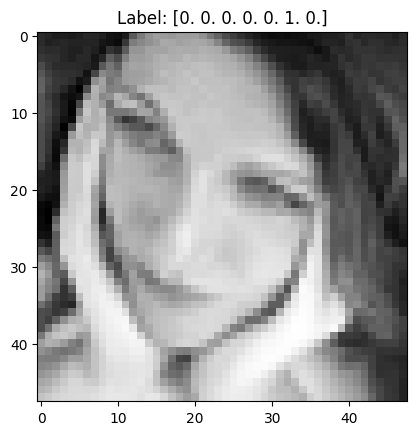

(1, 48, 48, 1)


In [118]:
# Load the training and validation datasets
train_ds = build_trainset("training")
val_ds = build_trainset("validation")

# Get the names of the labels
class_names = tuple(train_ds.class_names)

# Print one image
for image, label in train_ds.take(1):
    plt.imshow(image[0], cmap='gray')
    plt.title(f"Label: {label[0]}")
    plt.show()

# Print the shape of the images
for image, label in train_ds.take(1):
    print(image.shape)

In [119]:
print(class_names)

('angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised')


In [120]:
# Preprocessing of the data

# The pictures are 48x48 pixels, but the model requires 128x128 pixels
resize_layer = Lambda(lambda x: smart_resize(x, size=RE_SIZE))

# The model requires 3 channels, so we need to convert the grayscale image to RGB
grayscale_to_rgb_layer = Lambda(lambda x: grayscale_to_rgb(x))

# The model requires the input to be in the range [0, 1]
#normalization_layer = Rescaling(1. / 255)

# Create preprocessing model
preprocessing_model = Sequential()
preprocessing_model.add(resize_layer)
preprocessing_model.add(grayscale_to_rgb_layer)
#preprocessing_model.add(normalization_layer)

In [121]:
# Apply the preprocessing model to the training and validation datasets
train_ds = train_ds.map(lambda image, label: (preprocessing_model(image), label))
val_ds = val_ds.map(lambda image, label: (preprocessing_model(image), label))

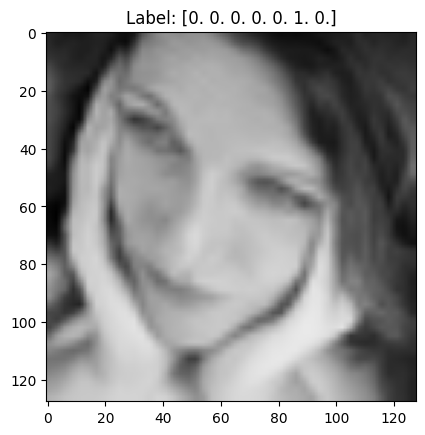

(1, 128, 128, 3)


In [123]:
# Print the same image after preprocessing
for image, label in train_ds.take(1):
    plt.imshow(image[0]*1/255)
    plt.title(f"Label: {label[0]}")
    plt.show()

# Print the shape of the images after preprocessing
for image, label in train_ds.take(1):
    print(image.shape)

In [124]:
# Get class names and the size of the data sets
train_size = train_ds.cardinality().numpy()
val_size = val_ds.cardinality().numpy()

train_ds = train_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

# Repeat training data set to ensure enough data
train_ds = train_ds.repeat()

In [125]:
# Load the EfficientNetV2 model as the base model and freeze the weights
# Don't add top layer and add our own top

base_model = EfficientNetV2B3(input_shape=(model_pixels, model_pixels, 3),
                             include_top=False,
                             weights='imagenet',
                             pooling=None)

base_model.trainable = False

# Add layers on top of the base model
model = Sequential([base_model,
                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dropout(0.2),
                    Dense(len(class_names), kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='softmax')])

# Build the model
model.build((None,)+(model_pixels, model_pixels)+(3,))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 4, 4, 1536)        12930622  
 nal)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 24576)             0         
                                                                 
 dense_12 (Dense)            (None, 1024)              25166848  
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 256)               262400    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                     

In [126]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [127]:
steps_per_epoch = train_size // (BATCH_SIZE * 2)
validation_steps = val_size // BATCH_SIZE

print(steps_per_epoch)
print(train_size)

721
23072


In [128]:
# Train the model

# Implement early stopping with patience 3
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

with tf.device('/device:GPU:0'):
  hist = model.fit(train_ds,
                   batch_size=BATCH_SIZE,
                   epochs=10,
                   steps_per_epoch=steps_per_epoch,
                   validation_data=val_ds,
                   validation_steps=validation_steps,
                   callbacks=[early_stopping]).history

Epoch 1/10
721/721 [==============================] - 108s 133ms/step - loss: 1.7233 - accuracy: 0.3918 - val_loss: 1.3923 - val_accuracy: 0.4849
Epoch 2/10
721/721 [==============================] - 25s 35ms/step - loss: 1.4406 - accuracy: 0.4619 - val_loss: 1.3660 - val_accuracy: 0.4884
Epoch 3/10
721/721 [==============================] - 25s 35ms/step - loss: 1.3433 - accuracy: 0.5043 - val_loss: 1.2518 - val_accuracy: 0.5236
Epoch 4/10
721/721 [==============================] - 25s 35ms/step - loss: 1.2999 - accuracy: 0.5110 - val_loss: 1.2572 - val_accuracy: 0.5286
Epoch 5/10
721/721 [==============================] - 25s 34ms/step - loss: 1.2468 - accuracy: 0.5398 - val_loss: 1.2264 - val_accuracy: 0.5439
Epoch 6/10
721/721 [==============================] - 25s 34ms/step - loss: 1.2187 - accuracy: 0.5443 - val_loss: 1.2437 - val_accuracy: 0.5363
Epoch 7/10
721/721 [==============================] - 24s 34ms/step - loss: 1.1616 - accuracy: 0.5694 - val_loss: 1.2366 - val_accurac

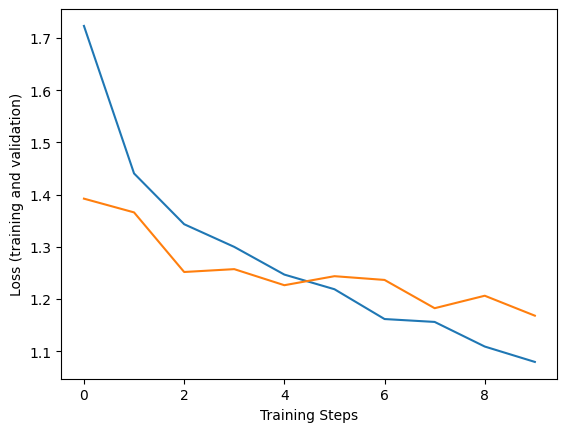

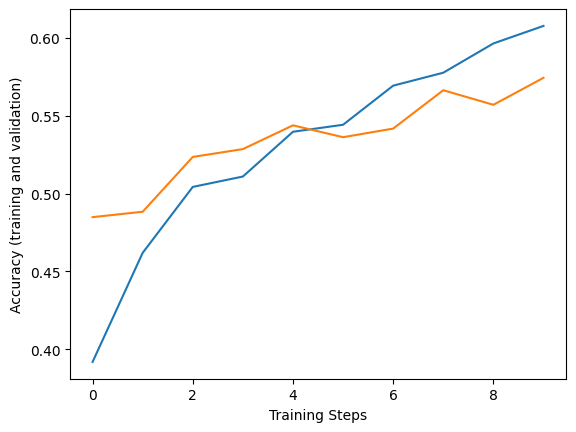

In [130]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
#plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
#plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

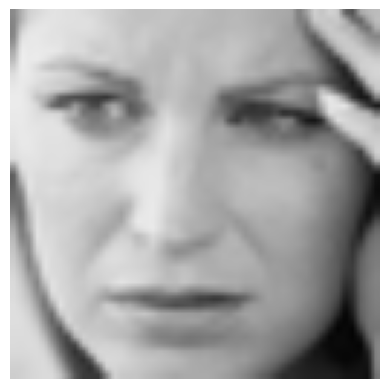

1/1 [==============================] - 2s 2s/step
True label: fearful
Predicted label: angry


In [131]:
x, y = next(iter(val_ds))
image = x[0, :, :, :] * 1 / 255
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [132]:
def build_testset():
    return image_dataset_from_directory(
                        f"drive/MyDrive/archive/test",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42)

In [133]:
# Build test set
test_ds = build_testset()

# Apply the preprocessing model to the test dataset
test_ds = test_ds.map(lambda x, y: (preprocessing_model(x), y))

Found 7178 files belonging to 7 classes.


In [134]:
from sklearn.metrics import confusion_matrix
predictions = []
y_true = []
y_pred = []

for image, label in test_ds:
    preds = model.predict(image, verbose=0)
    predictions.append(preds)
    predicted_label = np.argmax(preds, axis=1)
    y_true.append(np.argmax(label[0]))
    y_pred.append(predicted_label[0])

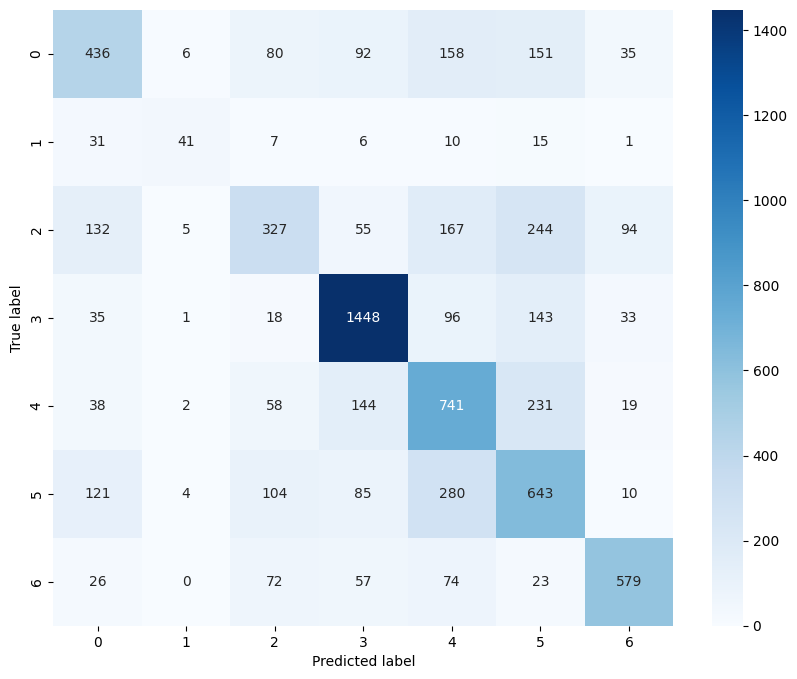

In [135]:
cm = confusion_matrix(y_true, y_pred)

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [136]:
# Calculate accuracy
y_pred = np.array(y_pred)
y_true = np.array(y_true)

label_diff = y_pred - y_true
correct_predictions = len(y_true) - np.count_nonzero(label_diff)

accuracy = correct_predictions / len(y_true)

print(accuracy)

0.5872109222624686


In [137]:
# Find out accuracy of each class

class_acc = np.zeros(len(cm))

for i in range(len(cm)):
  class_acc[i] = cm[i, i] / np.sum(cm[i, :])

print(class_acc)

[0.45511482 0.36936937 0.31933594 0.8162345  0.60097324 0.51563753
 0.6967509 ]


In [138]:
# Find out if this method works for saving the model

model.save("content/drive/MyDrive/efficientnet_v2_incl_rescaling.keras")

1/1 [==============================] - 0s 32ms/step


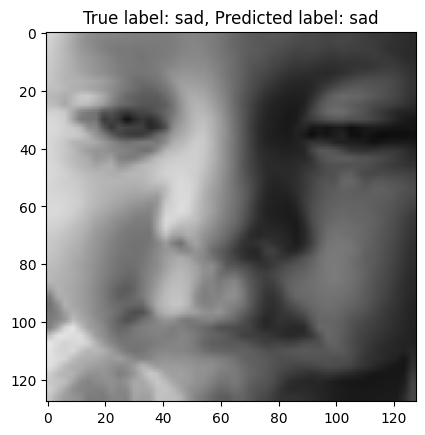

In [139]:
for image, label in test_ds.take(1):
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)
    plt.imshow(image[0]*1/255)
    plt.title(f"True label: {class_names[np.argmax(label[0])]}, Predicted label: {class_names[predicted_label[0]]}")
    plt.show()